# Lab 09: Using PySpark and MLlib for K-Means Clustering and Logistic Regression
Prepared by: **Hieng MAO**

### Objective
Learn how to
1. Set up a PySpark environment.
2. Perform K-means clustering using MLlib.
3. Build a Logistic Regression model using MLlib.
4. Evaluate and interpret the results.

### Prerequisites
- Software: Python 3.8+, PySpark (install via pip install pyspark), Java 8 or 11 (required
for Spark).
- Dataset: Use a sample dataset (e.g., Iris dataset or a synthetic dataset).
- Environment: Local machine or cloud-based environment (e.g., Jupyter Notebook,
Google Colab).

In [1]:
!pip install pyspark

In [59]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("MLlib Lab") \
    .getOrCreate()

print("Spark session created.")

Spark session created.


### Load or Create a Sample Dataset

In [60]:
# # Download Iris dataset
# !wget -O iris.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv
# !ls -l iris.csv
# !head -n 5 iris.csv

In [61]:
# Load the dataset into a DataFrame
df = spark.read.csv("iris.csv", header=True, inferSchema=True)

In [62]:
df.show(5)

+---+------------+-----------+------------+-----------+-----------+
| Id|sepal_length|sepal_width|petal_length|petal_width|    species|
+---+------------+-----------+------------+-----------+-----------+
|  1|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|  2|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|  3|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|  4|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|  5|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+---+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



### Data Preprocessing

In [63]:
# Remove Column Id
df = df.drop("Id")
df.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [64]:
from pyspark.ml.feature import VectorAssembler

# Create a feature vector
feature_columns = df.columns[:-1]  # All columns except the last one
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df)
df_vector.show(5)

+------------+-----------+------------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|
+------------+-----------+------------+-----------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+
only showing top 5 rows



## K-Means Clustering

In [112]:
from pyspark.ml.clustering import KMeans

# Initial KMeans model
kmeans = KMeans(k=3, seed=42).setFeaturesCol("features").setPredictionCol("cluster")

In [113]:
# Fit the model
k_model = kmeans.fit(df_vector)

In [114]:
# Make predictions
clustered_data = k_model.transform(df_vector)

In [115]:
clustered_data.select("features", "cluster").show(5)

+-----------------+-------+
|         features|cluster|
+-----------------+-------+
|[5.1,3.5,1.4,0.2]|      0|
|[4.9,3.0,1.4,0.2]|      0|
|[4.7,3.2,1.3,0.2]|      0|
|[4.6,3.1,1.5,0.2]|      0|
|[5.0,3.6,1.4,0.2]|      0|
+-----------------+-------+
only showing top 5 rows



### Evaluate Clustering
Compute the **Silhouette score** to evaluate the clustering quality.

In [116]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster")
silhouette = evaluator.evaluate(clustered_data)
print(f"Silhouette with squared euclidean distance = {silhouette}")

Silhouette with squared euclidean distance = 0.7342113066202725


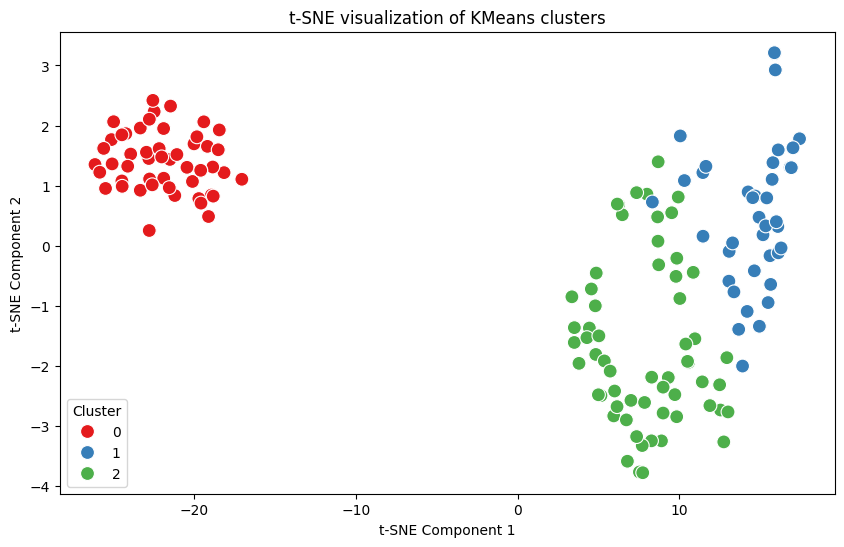

In [117]:
# Plotting the clusters in 2D using t-SNE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert to Pandas DataFrame
clustered_data_pd = clustered_data.select("features", "cluster").toPandas()
# Convert features to a 2D array
X = np.array(clustered_data_pd["features"].tolist())
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_tsne, columns=["x", "y"])
plot_df["cluster"] = clustered_data_pd["cluster"]
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="x", y="y", hue="cluster", palette="Set1", s=100)
plt.title("t-SNE visualization of KMeans clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

### Hyperparameters Tuning

In [118]:
# Tuning KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
# Create a parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [2, 3, 4, 5]) \
    .build()
# Create a CrossValidator
crossval = CrossValidator(estimator=kmeans,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=3)  # Use 3+ folds in practice

# Fit the model
cv_model = crossval.fit(df_vector)
# Get the best model
best_model = cv_model.bestModel
print(f"Best K: {best_model.getK()}")

25/04/29 04:00:00 WARN CacheManager: Asked to cache already cached data.
25/04/29 04:00:00 WARN CacheManager: Asked to cache already cached data.


Best K: 2


In [119]:
# Evaluate the best model
best_predictions = best_model.transform(df_vector)
silhouette = evaluator.evaluate(best_predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

Silhouette with squared euclidean distance = 0.8501515983265806


## Logistic Regression

### Prepare Data for Classification
For Logistic Regression, we need a numeric label column. Convert the categorical label or species column to numeric using StringIndexer.

In [71]:
from pyspark.ml.feature import StringIndexer

# Convert categorical labels to numerical labels
indexer = StringIndexer(inputCol="species", outputCol="label")
df_indexed = indexer.fit(clustered_data).transform(clustered_data)
df_indexed.show(5)

+------------+-----------+------------+-----------+-----------+-----------------+-------+-----+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|cluster|label|
+------------+-----------+------------+-----------+-----------+-----------------+-------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|      0|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|      0|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|      0|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|      0|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|      0|  0.0|
+------------+-----------+------------+-----------+-----------+-----------------+-------+-----+
only showing top 5 rows



### Data Splitting

In [72]:
# train-test split
train_data, test_data = df_indexed.randomSplit([0.7, 0.3], seed=42)

### Train the model

In [73]:
from pyspark.ml.classification import LogisticRegression

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

In [74]:
# Fit the model
lr_model = lr.fit(train_data)

In [75]:
# Make predictions on test data
predictions = lr_model.transform(test_data)
predictions.select("features", "label", "prediction").show(5)

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.4,3.0,1.3,0.2]|  0.0|       0.0|
|[4.6,3.2,1.4,0.2]|  0.0|       0.0|
|[4.6,3.6,1.0,0.2]|  0.0|       0.0|
|[4.7,3.2,1.3,0.2]|  0.0|       0.0|
|[4.8,3.1,1.6,0.2]|  0.0|       0.0|
+-----------------+-----+----------+
only showing top 5 rows



### Evaluate Logistic Regression

In [76]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")

Test set accuracy = 0.9782608695652174


In [85]:
# Evaluate precision, recall, and F1 score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Test set precision = {precision}")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Test set recall = {recall}")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"Test set F1 score = {f1}")

Test set precision = 0.9804347826086957
Test set recall = 0.9782608695652174
Test set F1 score = 0.978458139351377


### Visualization - Decision Boundary

In [125]:
from pyspark.ml.feature import PCA as sparkPCA
pca = sparkPCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_indexed)
X_vis = pca_model.transform(df_indexed)
X_vis.select("features", "pca_features").show(5)

+-----------------+--------------------+
|         features|        pca_features|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-2.8271359726790...|
|[4.9,3.0,1.4,0.2]|[-2.7959524821488...|
|[4.7,3.2,1.3,0.2]|[-2.6215235581650...|
|[4.6,3.1,1.5,0.2]|[-2.7649059004742...|
|[5.0,3.6,1.4,0.2]|[-2.7827501159516...|
+-----------------+--------------------+
only showing top 5 rows



In [96]:
# Predict all points 
y_vis_pred = lr_model.transform(df_pca)
y_vis_pred.select("features", "label", "prediction").show(5)

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[5.1,3.5,1.4,0.2]|  0.0|       0.0|
|[4.9,3.0,1.4,0.2]|  0.0|       0.0|
|[4.7,3.2,1.3,0.2]|  0.0|       0.0|
|[4.6,3.1,1.5,0.2]|  0.0|       0.0|
|[5.0,3.6,1.4,0.2]|  0.0|       0.0|
+-----------------+-----+----------+
only showing top 5 rows



In [ ]:
# Stop the Spark session
spark.stop()